# Workflow for processing  Fowler's Gap - 21JUN18 - Sentinel 2a

In [1]:
import numpy as np
import sys
sys.path.append("..")

import time
start_time = time.time()

#
# Set up input and output directories
#
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/Fowlers/21JUN18/'
output = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/FOW-MultiTimeLine/'

#
# field_data is in the format: 'Field Site Name', 'Date', 'Site number', 'Satellite Name'
# and 'Radiance'/'Reflectance'.
# NOTE: Satellite name should be one of: 'Landsat8', 'Sentinel2a', or 'Sentinel2b'.
#
field_data = ['FOW', '21JUN18', '', 'Sentinel2a', 'UQ_Panel', 'Radiance']

#
# bad_pans    contains the names of individual panels readings that appear to be bogus
# bad_grounds contains ground-reading file names that appear to be bogus
# Use empty lists if there are no bad spectra.
#
bad_grounds = []
bad_pans = []

ls8_bad_days = ['2013-04-13', '2013-05-15', '2013-05-31', '2013-06-16', '2013-08-19',
                '2013-10-22', '2013-12-09', '2014-03-15', '2014-05-02', '2014-05-18',
                '2014-06-03', '2014-06-19', '2014-12-28', '2015-01-13', '2015-04-03', '2015-05-21',
                '2015-06-06', '2015-07-24', '2015-08-25', '2015-12-15', '2015-12-31',
                '2016-05-07', '2016-06-08', '2016-06-24', '2016-07-10', '2016-08-11',
                '2016-09-12', '2016-10-30', '2017-01-18', '2017-02-03', '2017-03-07',
                '2017-04-08', '2017-06-27', '2017-07-13', '2017-08-14', '2017-12-04',
                '2017-12-20', '2018-02-22', '2018-03-26', '2018-05-13', '2018-05-29',
                '2018-07-16', '2018-09-02', '2018-10-04', '2018-10-20', '2018-11-05',
                '2018-12-07', '2019-01-08', '2019-03-29', '2019-04-14', '2019-04-30',
                '2019-06-01']
s2a_bad_days = ['2016-03-23', '2016-05-12', '2016-06-21', '2016-09-09', '2016-09-29', 
                '2016-11-18', '2016-12-08', '2016-12-28', '2017-06-16', '2017-11-23', 
                '2018-01-22', '2018-02-11', '2018-04-12', '2018-05-22', '2018-06-01', 
                '2018-06-11', '2018-07-31', '2018-08-30', '2018-10-09', '2019-01-27',
                '2019-02-16', '2019-02-26', '2019-04-17', '2019-05-27', '2019-06-06',
                '2019-06-16', '2019-07-06']
s2b_bad_days = ['2017-11-28', '2017-12-28', '2018-01-07', '2018-03-08', '2018-06-16',
                '2018-06-26', '2018-07-16', '2018-07-26', '2018-10-04', '2018-12-03', '2019-03-23', 
                '2019-04-22', '2019-05-02', '2019-05-22', '2019-06-01', '2019-06-11']

ls8_csvs = ['FOW_21JUN18__Landsat8.csv', 'FOW_18DEC18__Landsat8.csv']
sent_csvs = ['FOW_21JUN18__Sentinel2a.csv', 'FOW_18DEC18__Sentinel2.csv']

rain_dat = '../Weather/IDCJAC0009_046128_1800_Data.csv'

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 10
firstGoodGroundSpec = 20

#
# Calculated BRDF data
#
brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.07176400000000001, 0.023832, 0.005436],
                          ['band11', 0.44649200000000006, 0.12412400000000001, 0.039028],
                          ['band12', 0.37665200000000004, 0.08443600000000001, 0.033572000000000005],
                          ['band2', 0.07176400000000001, 0.023832, 0.005436],
                          ['band3', 0.13734400000000002, 0.042952, 0.011968000000000001],
                          ['band4', 0.242372, 0.060124000000000004, 0.023756000000000003],
                          ['band5', 0.242372, 0.060124000000000004, 0.023756000000000003],
                          ['band6', 0.242372, 0.060124000000000004, 0.023756000000000003],
                          ['band7', 0.344928, 0.12211600000000002, 0.028448000000000005],
                          ['band8', 0.344928, 0.12211600000000002, 0.028448000000000005],
                          ['band8a', 0.344928, 0.12211600000000002, 0.028448000000000005],
                         ])

#
# plot_scale defines the extent of the axes in the final two plots in the workflow.
# A scale from 0-1 means no reflectance to perfect reflectance. Typically, dark sites
# will range from 0-0.3, whereas bright sites will be between 0-1.
#
plot_scale = [0.0, 0.7, 0.0, 0.7]

#
# Define corners of field data, if GPS coordinates are NOT written into headers.
# Order is SE, SW, NE, NW. Units are decimal degrees.
# If there are no coordinates, then set RockWalk to either True or False.
# True  means that the field site was walked in a rock-like pattern (alternating directions),
# False means that the field site was walked in a roll-like pattern (same direction)
#
Corners = [-31.066231, 141.751203, -31.065954, 141.750214, -31.065408, 141.751642, -31.065085,141.750667]
RockWalk = True
StartCorner = 'SE'

In [2]:
import matplotlib.pyplot as plt
import matplotlib

#
# Astropy is used to determine the Solar angle
#
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u

import datacube

from CalVal import *

#
# Use notebook format (allows inline zooming and moving of figures)
# Set default font size for all plots
#
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['savefig.dpi'] = 300

In [3]:
#######################################
# LINES BELOW SHOULD REMAIN UNCHANGED #
#######################################
#
# panel_dir and in_panel refer to the file that is used in determining the k-factor,
# so this should remain unchanged.
#
if field_data[5] == 'Radiance':
    suffix = 'asd.rad.txt'
else: 
    suffix = 'asd.txt'

panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/Panels/'

if field_data[4] == 'GA_Panel':
    in_panel = 'ga_panel1_jan_2018.txt'
elif field_data[4] == 'CSIRO_Panel':
    in_panel = 'csiro_panel.txt'
elif field_data[4] == 'UA_Panel':
    in_panel = 'ua_panel.txt'
elif field_data[4] == 'UOW_Panel':
    in_panel = 'uow_panel.txt'
elif field_data[4] == 'UQ_Panel':
    in_panel = 'uq_panel.txt'
elif field_data[4] == 'CSIRO_VIC_Panel':
    in_panel = 'csiro_vic_panel.txt'
else:
    nopanel = '***PANEL NAME NOT KNOWN***'
    print(nopanel)

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Start Figure numbering at 1
#
fignum = 1



### Define 'alldata' as the dataframe that contains all the raw spectra.
Show the first wavelength of every spectrum, so that the data integrity can be checked.

In [4]:
alldata = LoadData.load_from_dir(indir, suffix, firstGoodLine, Corners)

alldata[alldata['Wavelength']==350]

Wavelength  radiance               filename          date_saved  \
0          350  0.080650  FOWLERS_00010.asd.rad 2018-06-21 01:07:25   
0          350  0.080810  FOWLERS_00011.asd.rad 2018-06-21 01:07:28   
0          350  0.080894  FOWLERS_00012.asd.rad 2018-06-21 01:07:30   
0          350  0.080346  FOWLERS_00013.asd.rad 2018-06-21 01:07:33   
0          350  0.080421  FOWLERS_00014.asd.rad 2018-06-21 01:07:35   
0          350  0.080289  FOWLERS_00015.asd.rad 2018-06-21 01:07:38   
0          350  0.080248  FOWLERS_00016.asd.rad 2018-06-21 01:07:40   
0          350  0.080320  FOWLERS_00017.asd.rad 2018-06-21 01:07:43   
0          350  0.080376  FOWLERS_00018.asd.rad 2018-06-21 01:07:45   
0          350  0.080276  FOWLERS_00019.asd.rad 2018-06-21 01:07:48   
0          350  0.002466  FOWLERS_00020.asd.rad 2018-06-21 01:11:25   
0          350  0.002307  FOWLERS_00021.asd.rad 2018-06-21 01:11:28   
0          350  0.003041  FOWLERS_00022.asd.rad 2018-06-21 01:11:30   
0          350  0.002671  FOWLERS_00023.asd.rad 2018-06-21 01:11:34   
0          350  0.003168  FOWLERS_00024.asd.rad 2018-06-21 01:11:39   
0          350  0.002870  FOWLERS_00025.asd.rad 2018-06-21 01:11:42   
0          350  0.002881  FOWLERS_00026.asd.rad 2018-06-21 01:11:44   
0          350  0.002868  FOWLERS_00027.asd.rad 2018-06-21 01:11:47   
0          350  0.002690  FOWLERS_00028.asd.rad 2018-06-21 01:11:49   
0          350  0.003160  FOWLERS_00029.asd.rad 2018-06-21 01:11:52   
0          350  0.003714  FOWLERS_00030.asd.rad 2018-06-21 01:12:17   
0          350  0.002857  FOWLERS_00031.asd.rad 2018-06-21 01:12:20   
0          350  0.002600  FOWLERS_00032.asd.rad 2018-06-21 01:12:22   
0          350  0.002757  FOWLERS_00033.asd.rad 2018-06-21 01:12:25   
0          350  0.002452  FOWLERS_00034.asd.rad 2018-06-21 01:12:27   
0          350  0.003005  FOWLERS_00035.asd.rad 2018-06-21 01:12:30   
0          350  0.003176  FOWLERS_00036.asd.rad 2018-06-21 01:12:32   
0          350  0.003113  FOWLERS_00037.asd.rad 2018-06-21 01:12:35   
0          350  0.002847  FOWLERS_00038.asd.rad 2018-06-21 01:12:39   
0          350  0.002429  FOWLERS_00039.asd.rad 2018-06-21 01:12:41   
..         ...       ...                    ...                 ...   
0          350  0.003332  FOWLERS_00390.asd.rad 2018-06-21 02:00:14   
0          350  0.003376  FOWLERS_00391.asd.rad 2018-06-21 02:00:16   
0          350  0.003453  FOWLERS_00392.asd.rad 2018-06-21 02:00:19   
0          350  0.003457  FOWLERS_00393.asd.rad 2018-06-21 02:00:21   
0          350  0.003769  FOWLERS_00394.asd.rad 2018-06-21 02:00:24   
0          350  0.003653  FOWLERS_00395.asd.rad 2018-06-21 02:00:26   
0          350  0.003306  FOWLERS_00396.asd.rad 2018-06-21 02:00:29   
0          350  0.003339  FOWLERS_00397.asd.rad 2018-06-21 02:00:31   
0          350  0.003626  FOWLERS_00398.asd.rad 2018-06-21 02:00:34   
0          350  0.003607  FOWLERS_00399.asd.rad 2018-06-21 02:00:36   
0          350  0.002960  FOWLERS_00400.asd.rad 2018-06-21 02:01:02   
0          350  0.003315  FOWLERS_00401.asd.rad 2018-06-21 02:01:05   
0          350  0.003264  FOWLERS_00402.asd.rad 2018-06-21 02:01:07   
0          350  0.002971  FOWLERS_00403.asd.rad 2018-06-21 02:01:10   
0          350  0.003318  FOWLERS_00404.asd.rad 2018-06-21 02:01:12   
0          350  0.003001  FOWLERS_00405.asd.rad 2018-06-21 02:01:15   
0          350  0.003098  FOWLERS_00406.asd.rad 2018-06-21 02:01:18   
0          350  0.003264  FOWLERS_00407.asd.rad 2018-06-21 02:01:20   
0          350  0.003110  FOWLERS_00408.asd.rad 2018-06-21 02:01:23   
0          350  0.003047  FOWLERS_00409.asd.rad 2018-06-21 02:01:25   
0          350  0.003232  FOWLERS_00410.asd.rad 2018-06-21 02:01:51   
0          350  0.003436  FOWLERS_00411.asd.rad 2018-06-21 02:01:53   
0          350  0.003447  FOWLERS_00412.asd.rad 2018-06-21 02:01:56   
0          350  0.003914  FOWLERS_00413.asd.rad 2018-06-21 02:01:59   
0          350  0.003359  FO

### Print out time stamp and coordinate extent for BRDF correction

The time stamp and Lat/Long extents are required to calculate the BRDF correction, used below.

In order to calculate the BRF correction, the following method is used:

<OL>
    <LI>Run the print statements in the cell below.</LI>
    <LI>Copy and paste the output into a VDI terminal window</LI>
    <LI>Copy and paste the resultant VDI output into the BRDF calculation cell, writing over the similar text.</LI>
</OL>

NOTE: This works assuming that the BRDF code is in the current directory.


In [5]:
PrintBRDF.print_brdf(alldata, field_data)

#################################################################################
# Copy and paste the following into a terminal window on VDI for Landsat 8 data #
#################################################################################

source module_C5.sh
sed -i "40s/.*/        self.acquisition_datetime = dateutil.parser.parse('2018-06-21 01:07:25')/" retrieve_brdf_C5.py
sed -i "43s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(141.751203, -31.066231, 141.751203, -31.066231)]})/" retrieve_brdf_C5.py
python retrieve_brdf_C5.py > temp.txt ; awk -f format_Sent.awk temp.txt



### Specify which spectra are panels/ground/good/bad

 Determine panel file names by assuming that all panels have a data value of at least 0.06
 in the first wavelength (350nm). Call this dataframe 'panel_names'.

 good_panels = all panel data with bad panels removed<BR>
 bad_panels  = all bad panel data<BR>
 all_panels = both good and bad panel data<BR>
 good_grounds = good ground readings<BR>
 all_grounds = all ground data.<P>
 Any bad ground data (bad_grounds) is defined in the 2nd cell.


In [6]:
panel_names, all_panels, good_panels, bad_panels, good_grounds, all_grounds = ExtractPanelsGrounds.extract_panels_grounds(alldata, bad_pans, bad_grounds, field_data)

### Create dataframes for all/good/bad panel spectra.

For the bad panel spectra dataframe, first check to see if bad panels have been defined.<BR>
If not, then don't create anything.

In [7]:
all_panel_spec = MakeSpecDF.make_spec_df(all_panels, field_data)
good_panel_spec = MakeSpecDF.make_spec_df(good_panels, field_data)
try:
    bad_panel_spec = MakeSpecDF.make_spec_df(bad_panels, field_data)
except UnboundLocalError:
    pass

# Figure 

### Plot panel radiances for all/good/bad panels

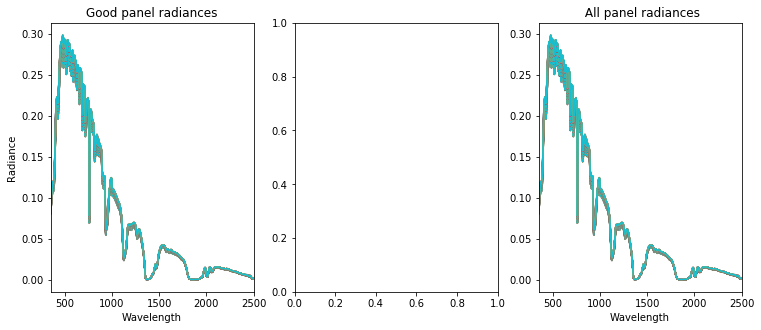

In [8]:
try:
    FIG_PanelRadiances.FIG_panel_radiances(good_panel_spec, bad_panel_spec, all_panel_spec, output, field_data, fignum)
except NameError:
    bad_panel_spec = [0,0]
    FIG_PanelRadiances.FIG_panel_radiances(good_panel_spec, bad_panel_spec, all_panel_spec, output, field_data, fignum)

fignum += 1

# Figure 

### Diagnosis plots of bad panel spectra

In [9]:
good_panel_mean = good_panel_spec.mean(axis=1)

try:
    FIG_BadPanelAnalysis.FIG_bad_panel_analysis(good_panel_mean, good_panel_spec, bad_panel_spec, output, field_data, fignum)
except AttributeError:
    pass
fignum +=1

### Create spectral dataframes for all ground spectra and good ground spectra

In [10]:
all_grounds_spec = MakeSpecDF.make_spec_df(all_grounds, field_data)
good_grounds_spec = MakeSpecDF.make_spec_df(good_grounds, field_data)

# Figure 

### Plot ground spectra (all and good), normalised to the median good spectrum

These plots are used to identify any ground spectra that are bogus.

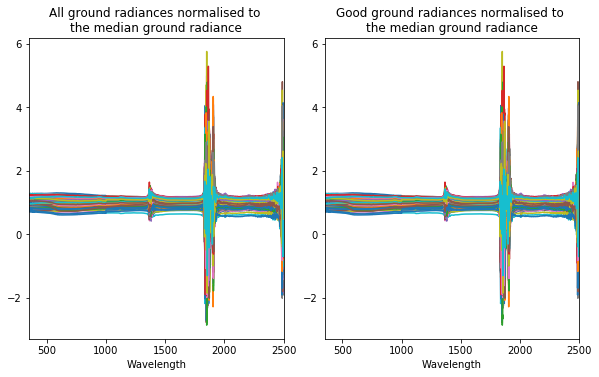

In [11]:
FIG_GroundSpectra.FIG_ground_spectra(good_grounds_spec, all_grounds_spec, output, field_data, fignum)
fignum +=1

### Create time-relative dataframes

gpt = good panels<BR>
gpta = all panels<BR>
adt = good grounds<BR>
adta = all grounds

In [12]:
gpt, gpta, adt, adta = CreateTimeRelativeDF.create_time_relative_dfs(good_panels, all_panels, good_grounds, all_grounds)

# Figure 

### Plot timelines for ALL panel and ground data, with one line in one panel

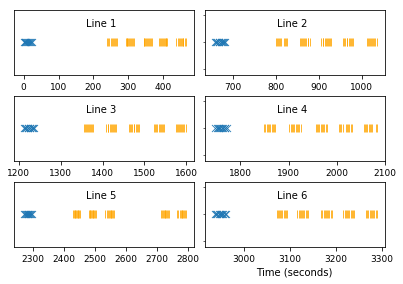

In [13]:
FIG_AllTimelines.FIG_all_timelines(gpta, adta, output, field_data, fignum)
fignum += 1

# Figure 

### Plot timelines for GOOD panel and ground data, with one line in one panel

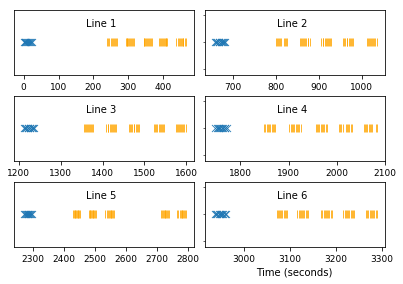

In [14]:
from CalVal.FIG_AllTimelines import panel_plot_layout, multi_timeline_plot

FIG_GoodTimelines.FIG_good_timelines(gpta, gpt, adt, panel_plot_layout, multi_timeline_plot, output, field_data, fignum)
fignum += 1

# Figure 

### Create timeline plot of averaged, normalised all/good panels

These plots are used to identify any panels that show unusually bright or dark readings,<BR>
    which can be weeded out as bad panels.
    
The general shape of the curve should follow "insolation" - the changing of incident light
due to the Sun rising/falling in the sky.

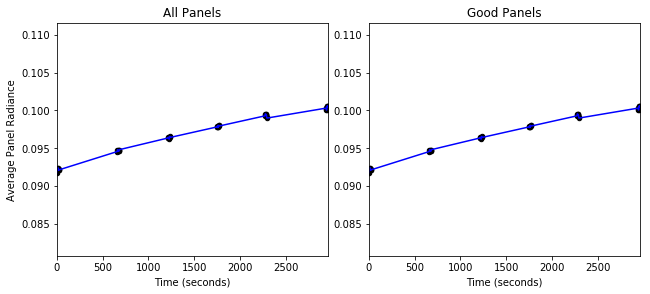

In [15]:
gpt, gpta = FIG_NormalisedPanelsTimeline.normalise_spectra(good_panel_mean, good_panel_spec, all_panel_spec, gpt, gpta, field_data)
    
FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(gpt, gpta, output, field_data, fignum)
fignum += 1

### Define the K-factor

This reads a standard file with a response curve for the detector, given an ideally white surface.<BR>
Then "k_f" is defined for the K-factor.

In [16]:
k_f = KFactor.k_factor(panel_dir, in_panel)

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [17]:
SpecRename.spec_rename(good_panel_spec, good_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec, field_data)

### Create dataframe with Reflectances

In [18]:
all_refls = CreateReflectances.create_reflectances(good_panels, good_panel_spec, good_grounds_spec, k_f, field_data)

### Test for reflectances
Test field_data to see if the data were saved as reflectances. If so, bypass all the panelling workflow.

In [19]:
if field_data[5] == 'Reflectance':
    all_refls = good_grounds_spec

# Figure 

### Plot all ground reflectances in black, plus the Line-averaged reflectances in colour

The Line-averaged reflectances are shown in order to identify any outlying lines that<BR>

might have been caused by bad panel spectra (for example).

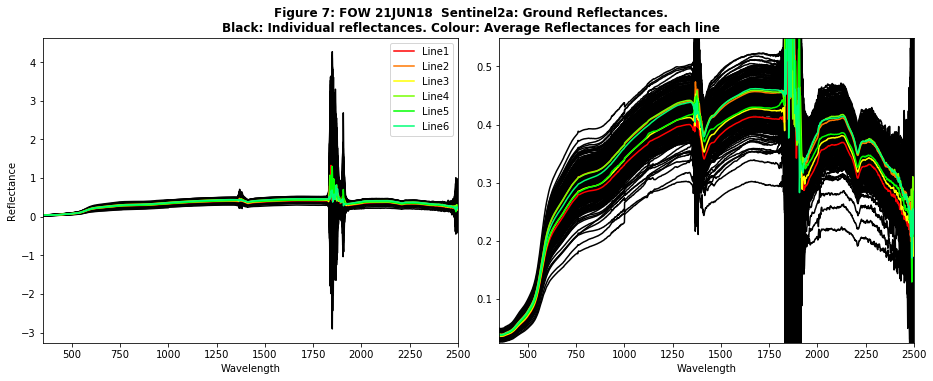

In [20]:
FIG_Reflectances.FIG_reflectances(good_panels, all_refls, colpac, output, field_data, fignum)
fignum += 1

### Apply weighted band responses to all reflectances

In [21]:
f_name = sat_resp['Landsat8']
result_ls8_df, dummy, band_ls8, dummy2 = ApplyWeights.apply_weights(f_name, all_refls, sat_resp, field_data)
f_name = sat_resp['Sentinel2a']
dummy, result_s2a_df, dummy2, band_s2a = ApplyWeights.apply_weights(f_name, all_refls, sat_resp, field_data)
f_name = sat_resp['Sentinel2b']
dummy, result_s2b_df, dummy2, band_s2b = ApplyWeights.apply_weights(f_name, all_refls, sat_resp, field_data)

### Reformat band reflectances and apply to dataframe "ground_bands"

In [22]:
ground_bands_ls8 = ReformatDF.reformat_df(good_grounds, result_ls8_df)
ground_bands_s2a = ReformatDF.reformat_df(good_grounds, result_s2a_df)
ground_bands_s2b = ReformatDF.reformat_df(good_grounds, result_s2b_df)

# Figure 

### Plot band reflectances

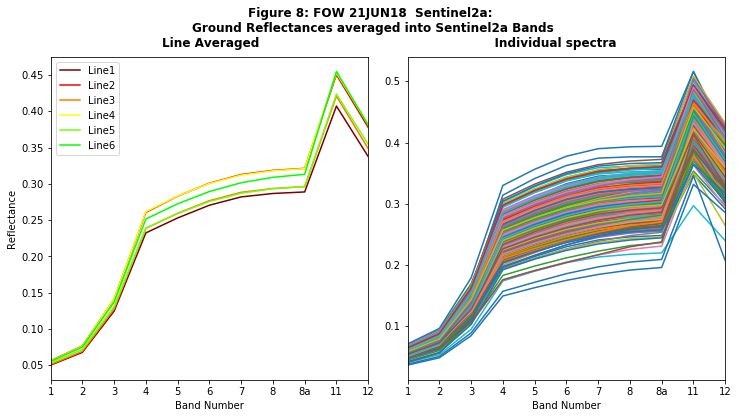

In [23]:
FIG_BandReflectances.FIG_band_reflectances(ground_bands_ls8, result_ls8_df, band_ls8, ground_bands_s2a, result_s2a_df, band_s2a, colpac, output, field_data, fignum)
fignum += 1
#FIG_BandReflectances.FIG_band_reflectances(ground_bands_s2a, result_s2a_df, band_s2a, colpac, output, field_data, fignum)
#fignum += 1

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

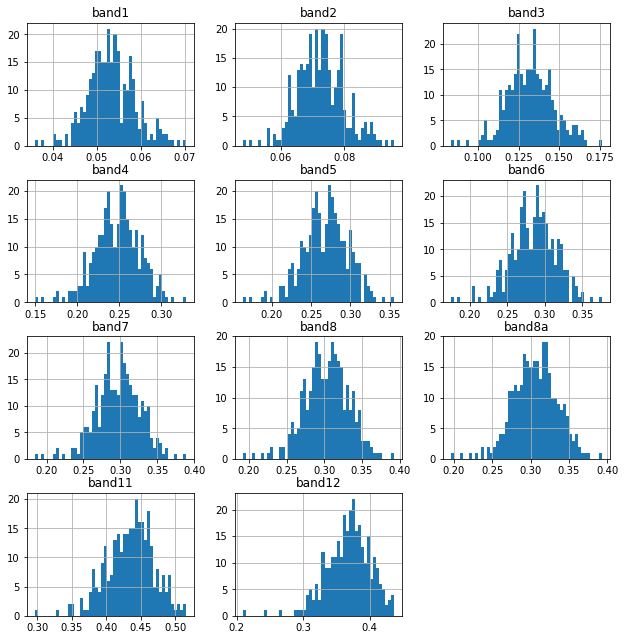

In [24]:
FIG_SpecHistogram.FIG_spec_histogram(ground_bands_ls8, ground_bands_s2b, output, field_data, fignum)
fignum += 1

### Outlying ground spectra

Display the spectra with maximum and minimum values. These can be compared to the histograms above<BR>
    to identify any outlying spectra that need to be identified as bad ground spectra.

In [25]:
maxfile = ground_bands_s2b['filename'][(ground_bands_s2b['band1'] == ground_bands_s2b['band1'].max())]
maxbands = ground_bands_s2b.filter(like='band')[(ground_bands_s2b['band1'] == ground_bands_s2b['band1'].max())]
minfile = ground_bands_s2b['filename'][(ground_bands_s2b['band1'] == ground_bands_s2b['band1'].min())]
minbands = ground_bands_s2b.filter(like='band')[(ground_bands_s2b['band1'] == ground_bands_s2b['band1'].min())]

print("Maximum value found in:", maxfile.iloc[0], '\n', maxbands.iloc[0], '\nMinimum value found in:', minfile.iloc[0], '\n', minbands.iloc[0])
#print(ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].max())], '\n',ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].max())])
#print(ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].min())], '\n',ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].min())])


Maximum value found in: FOWLERS_00130.asd.rad 
 band1     0.070387
band2     0.095798
band3     0.176486
band4     0.330023
band5     0.356066
band6     0.376971
band7     0.389489
band8     0.393035
band8a    0.393784
band11    0.515693
band12    0.420568
Name: 90, dtype: float64 
Minimum value found in: FOWLERS_00300.asd.rad 
 band1     0.035910
band2     0.047904
band3     0.083239
band4     0.149166
band5     0.162508
band6     0.174242
band7     0.183745
band8     0.191465
band8a    0.195549
band11    0.330946
band12    0.289049
Name: 200, dtype: float64


### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [26]:
def solar_angle(row):

    loc = coord.EarthLocation(lon=row['Longitude'] * u.deg,
                              lat=row['Latitude'] * u.deg)
    #timy0 = timei.to_pydatetime()
    timy = Time(row['date_saved'], format='datetime')
    
    altaz = coord.AltAz(location=loc, obstime=timy)
    sun = coord.get_sun(timy)

    return sun.transform_to(altaz).zen.degree

ground_bands_ls8['Solar_angle'] = ground_bands_ls8.apply(solar_angle, axis=1)
ground_bands_s2a['Solar_angle'] = ground_bands_s2a.apply(solar_angle, axis=1)
ground_bands_s2b['Solar_angle'] = ground_bands_s2b.apply(solar_angle, axis=1)

### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [27]:
ground_brdf_ls8, dummy, hb, br = BRDF.ReadAndCalc(brdf_data, ground_bands_ls8, ground_bands_s2a, ['','','','Landsat8'])
dummy, ground_brdf_s2a, hb, br = BRDF.ReadAndCalc(brdf_data, ground_bands_ls8, ground_bands_s2a, ['','','','Sentinel2a'])
dummy, ground_brdf_s2b, hb, br = BRDF.ReadAndCalc(brdf_data, ground_bands_ls8, ground_bands_s2b, ['','','','Sentinel2b'])

### Choose bands for Landsat 8 and Sentinel satellite data

In [28]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

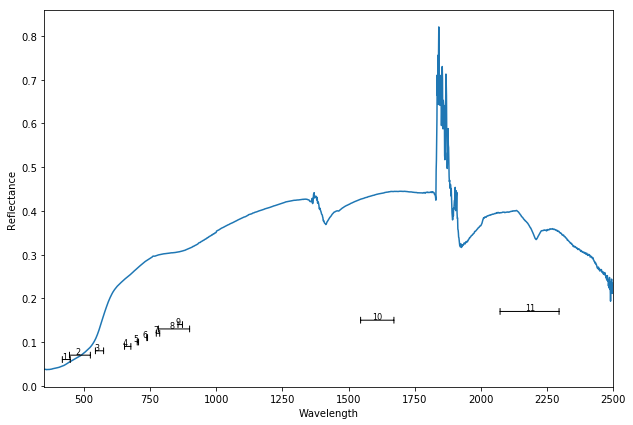

In [29]:
FIG_BandExtents.FIG_band_extents(all_refls, band_min, band_max, output, field_data, fignum)
fignum += 1

### Fudge GPS locations if none exist

In [30]:
ground_brdf_ls8 = FudgeGPS.fudge_gps(ground_brdf_ls8, Corners, RockWalk, StartCorner)
ground_brdf_s2a = FudgeGPS.fudge_gps(ground_brdf_s2a, Corners, RockWalk, StartCorner)
ground_brdf_s2b = FudgeGPS.fudge_gps(ground_brdf_s2b, Corners, RockWalk, StartCorner)

No good GPS Coordinates found, fudging...
No good GPS Coordinates found, fudging...
No good GPS Coordinates found, fudging...


### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.

In [31]:
ldc, sdc, lquery, squery, lquery2, squery2 = LongQuery.make_long_query(ground_brdf_ls8)

ls8_array, s2a_array, s2b_array, ls8_bigarray, s2a_bigarray, s2b_bigarray = CreateLongArrays.create_long_arrays_nomask(ldc, sdc, lquery, squery, lquery2, squery2)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series

# Figure 

### Plot relative locations of field and satellite data

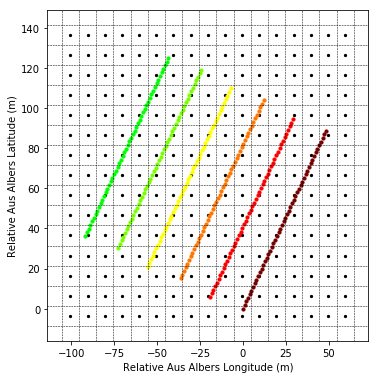

In [32]:
xloc, sxloc = FIG_SatFieldLocations.FIG_sat_field_locations(ground_brdf_ls8, ground_brdf_s2a, ls8_array, s2a_array, colpac, output, field_data, fignum)
fignum +=1

#ls_xloc, s2_xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ls_ground_brdf, s2_ground_brdf, ls_sat_array, s2_sat_array, colpac, output, field_data, fignum)
#fignum +=1

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [33]:
field_array_ls8, field_array_s2a = CreateManyFieldFromSat.create_many_field_from_sat(ls8_array, s2a_array, ground_brdf_ls8, ground_brdf_s2a, xloc)

# Figure 

### Plot large-area context RGB array for Satellite data

Landsat 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

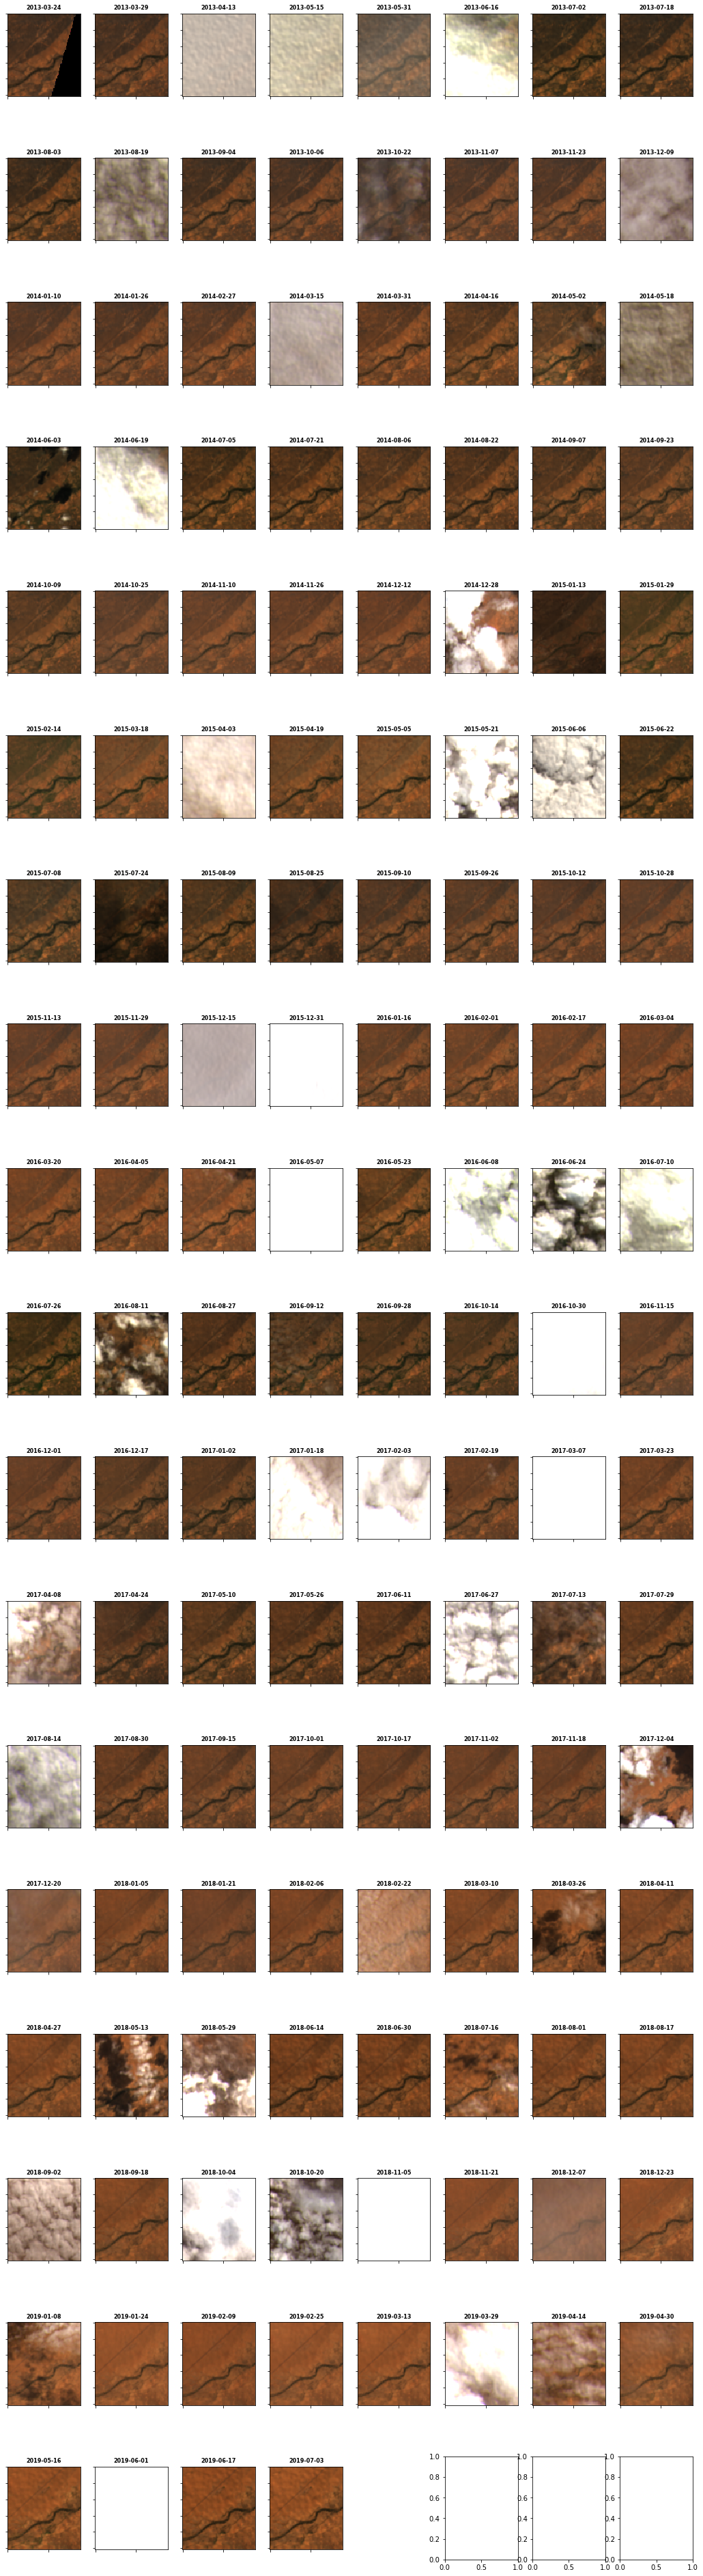

In [34]:
FIG_ManyLS8RGB.FIG_many_LS8RGB(ls8_bigarray, output, field_data, fignum)
fignum += 1

Sentinel 2a


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

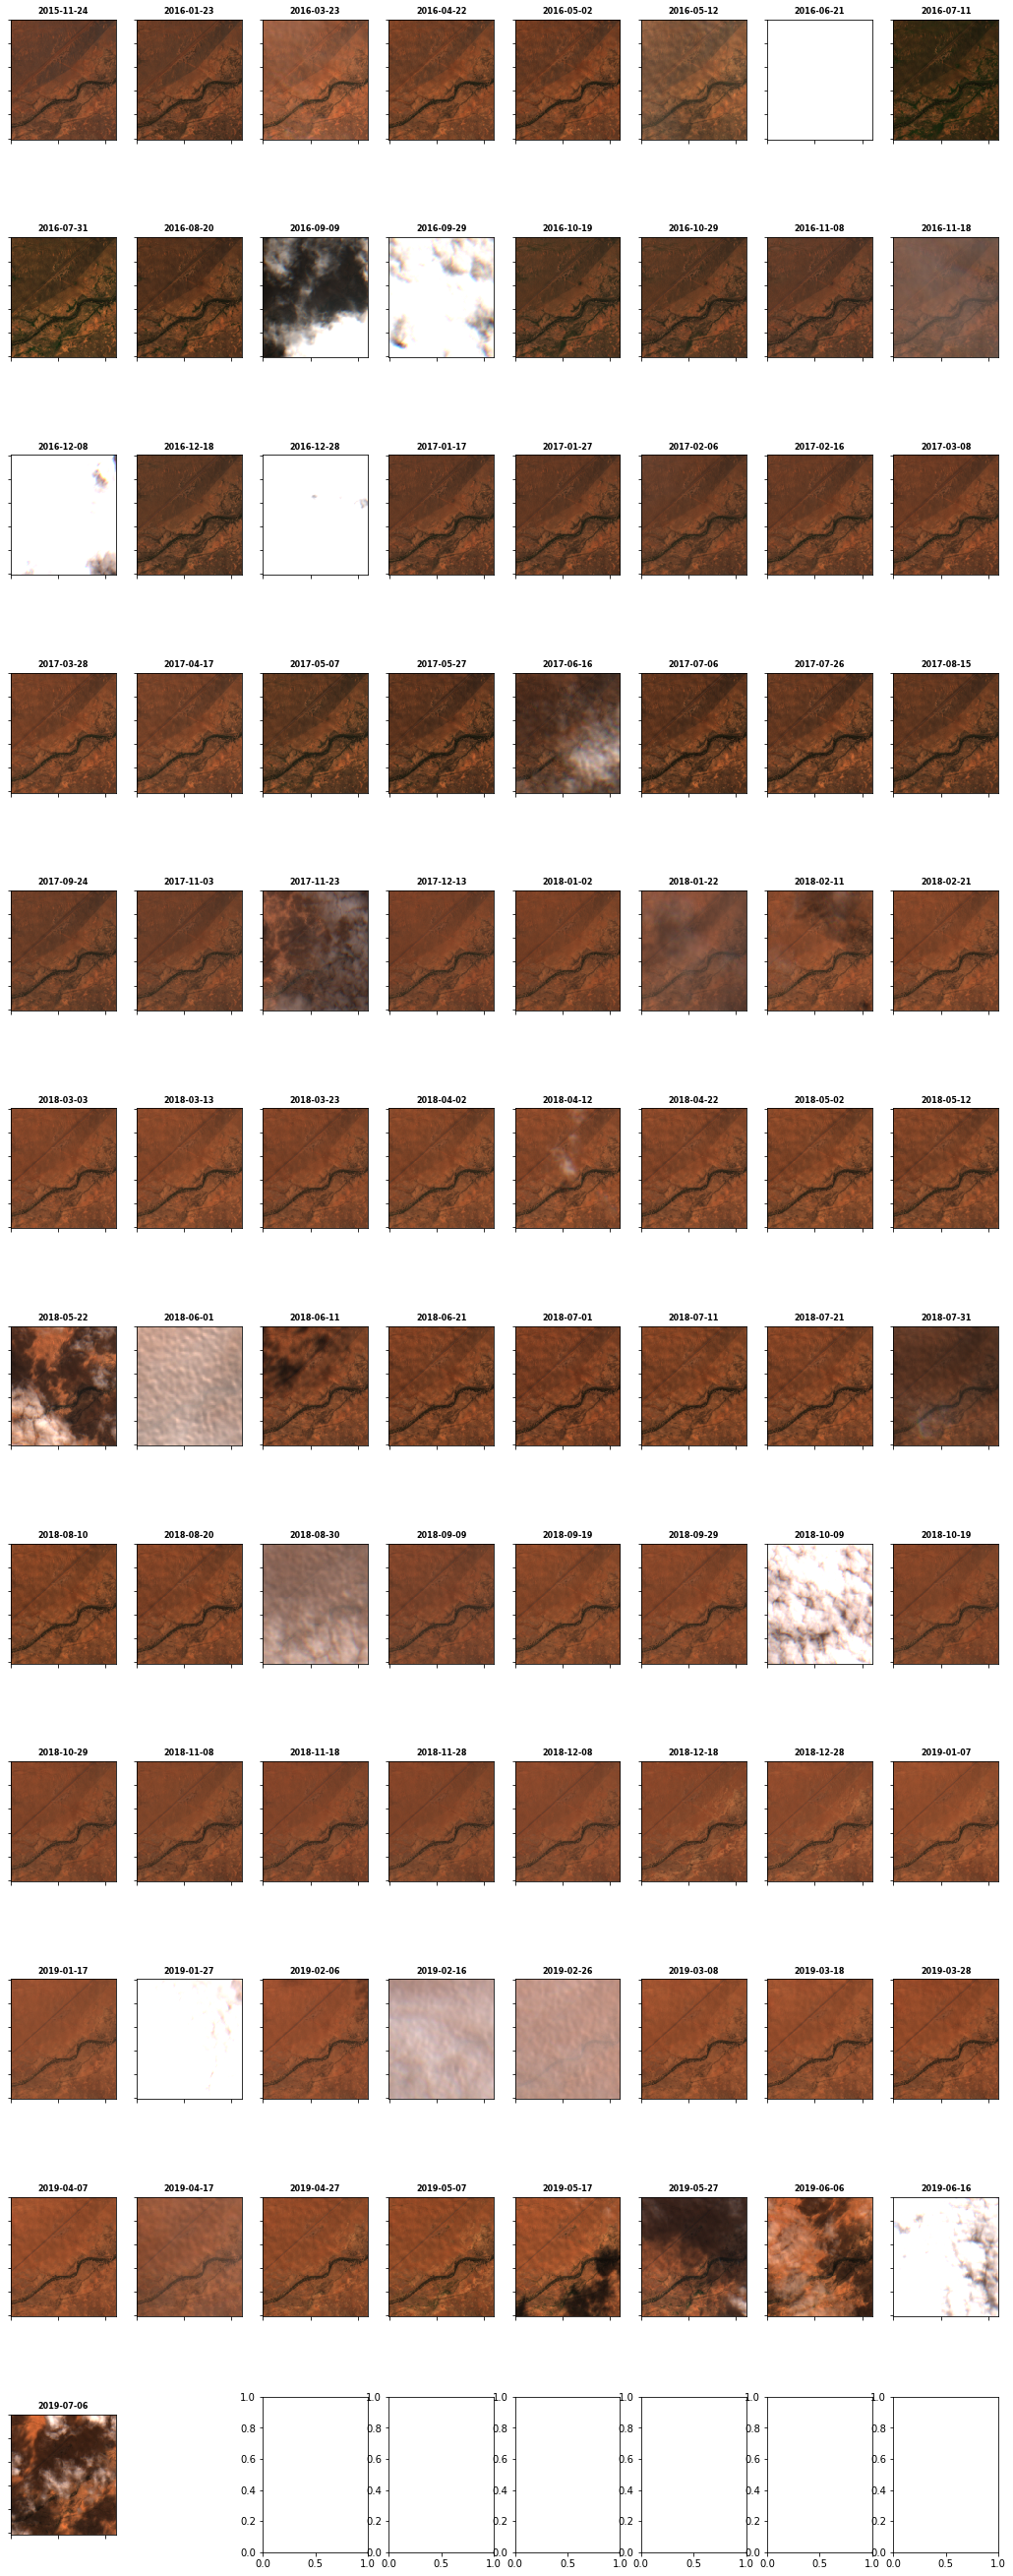

In [35]:
FIG_ManyS2ARGB.FIG_many_S2ARGB(s2a_bigarray, output, field_data, fignum)
fignum += 1

Sentinel 2b


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

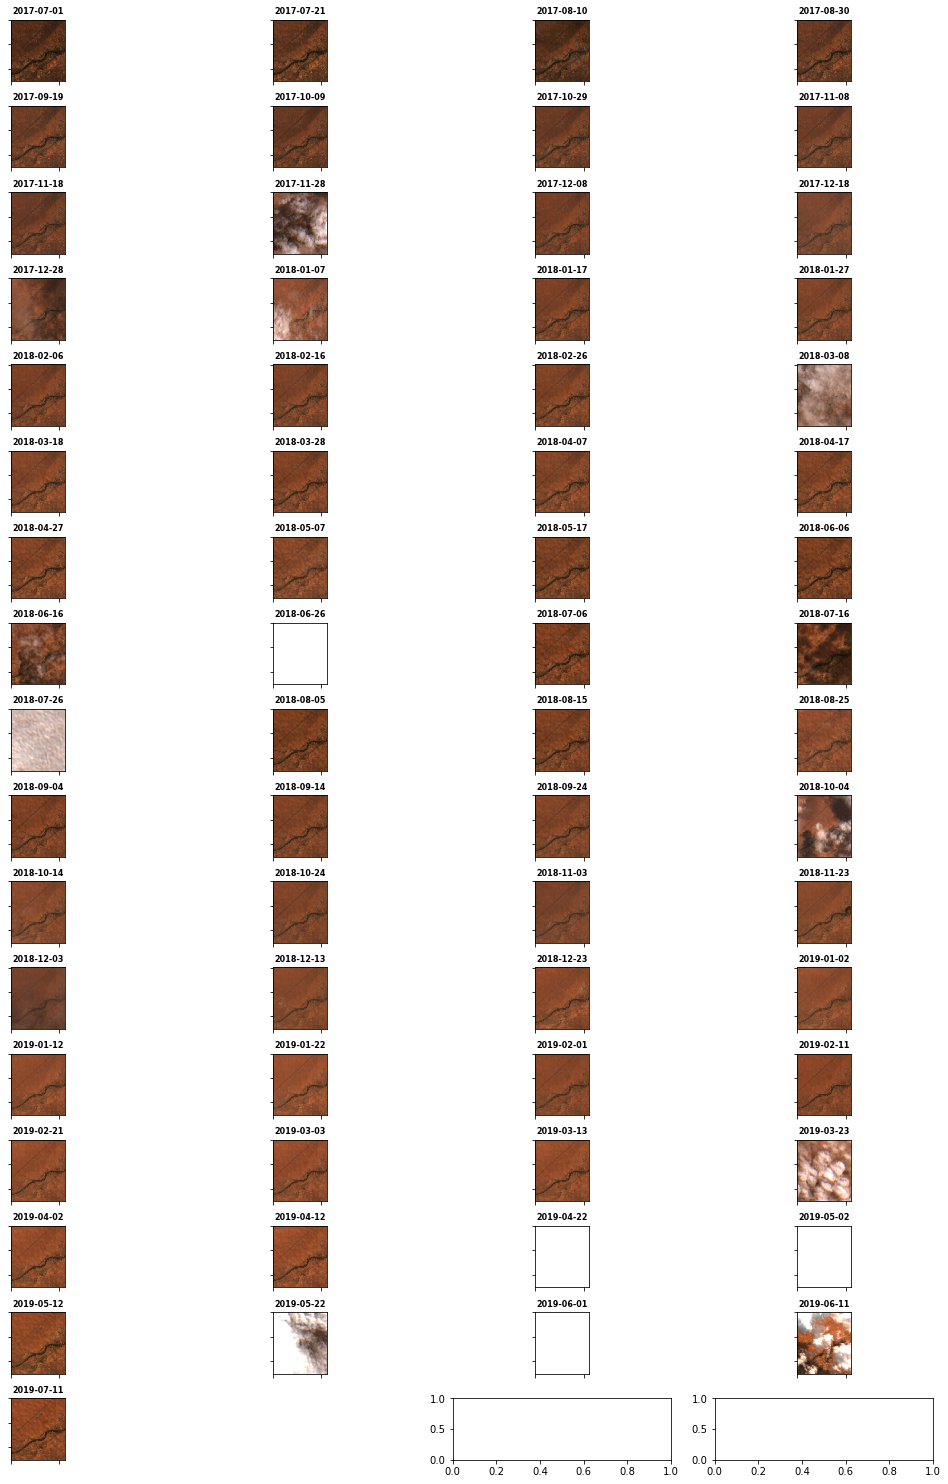

In [36]:
FIG_ManyS2BRGB.FIG_many_S2BRGB(s2b_bigarray, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Field data

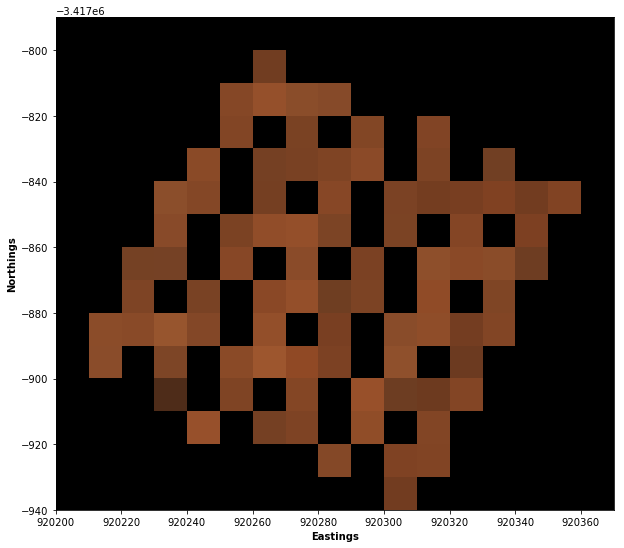

In [37]:
FIG_FieldRGB.FIG_field_RGB(field_array_s2a, output, field_data, fignum)
fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [38]:
fls8_df, fs2a_df, fs2b_df = CreateManyStats.create_manystats(ls8_array, s2a_array, s2b_array, ls8_bad_days, s2a_bad_days, s2b_bad_days, ground_brdf_ls8, ground_brdf_s2a, field_data)

# Figure

### Plot comparison spectra of satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the satellite and field data, based on the standard deviation of the pixels
within the field. The black line shows the satellite data, which has been averaged over all pixels that satisfy the Datacube query ie. all pixels shown in Figure 11. The orange line shows satellite data which has been averaged over only those pixels that overlap with at least one field measurement.

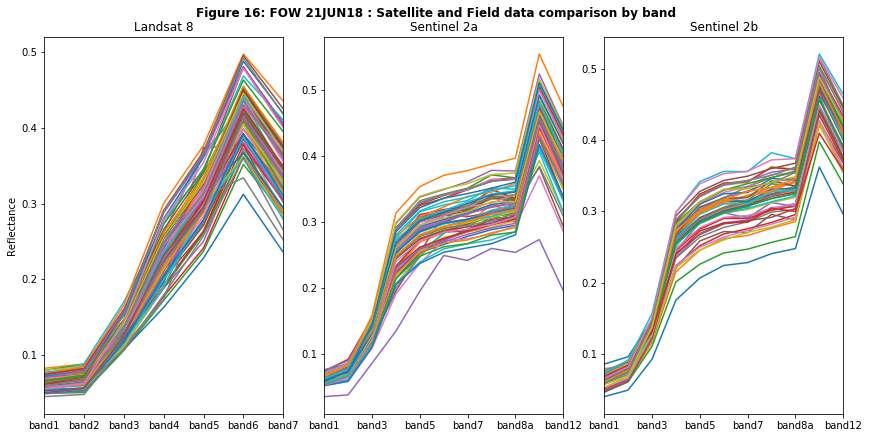

In [39]:
FIG_ManySatFieldBands.FIG_many_sat_field_bands(ls8_array, s2a_array, s2b_array, fls8_df, fs2a_df, fs2b_df, output, field_data, fignum)
fignum += 1

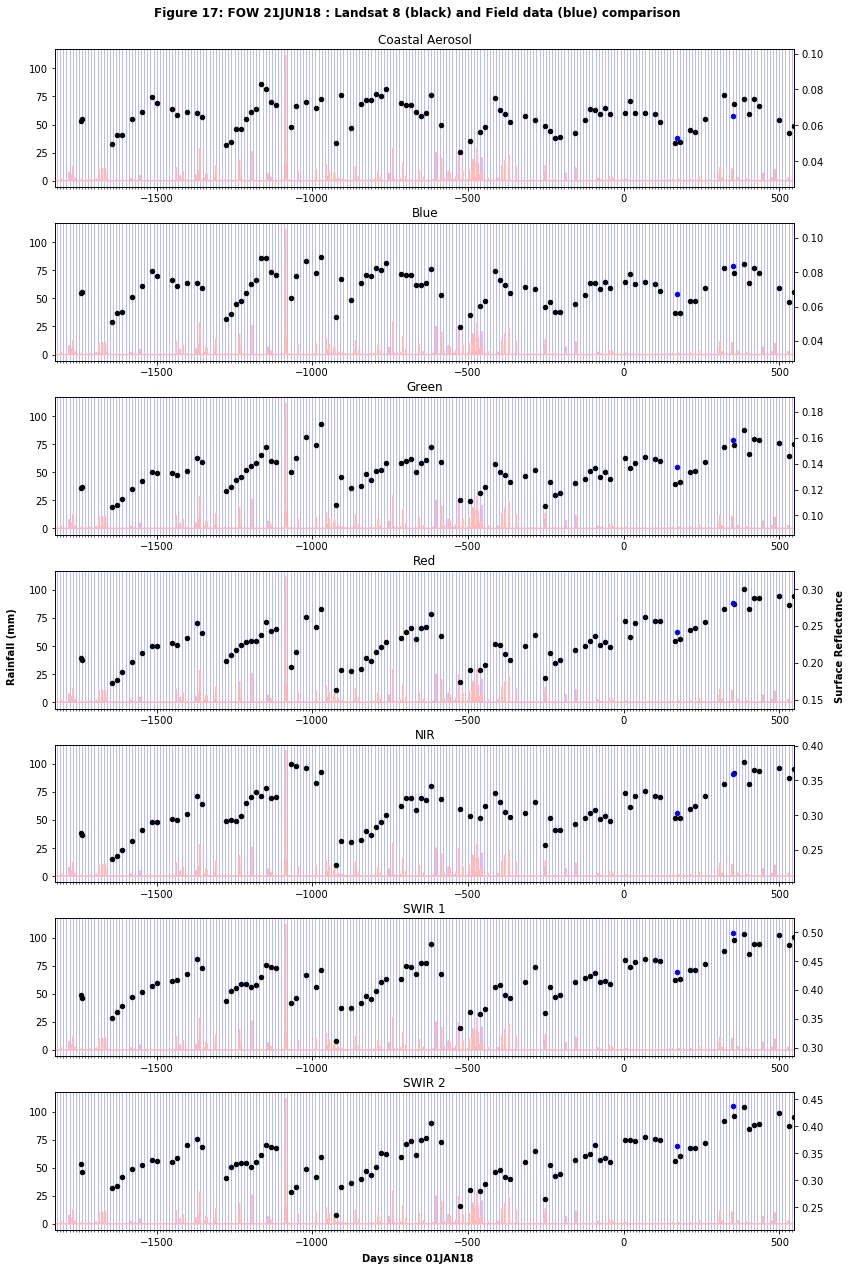

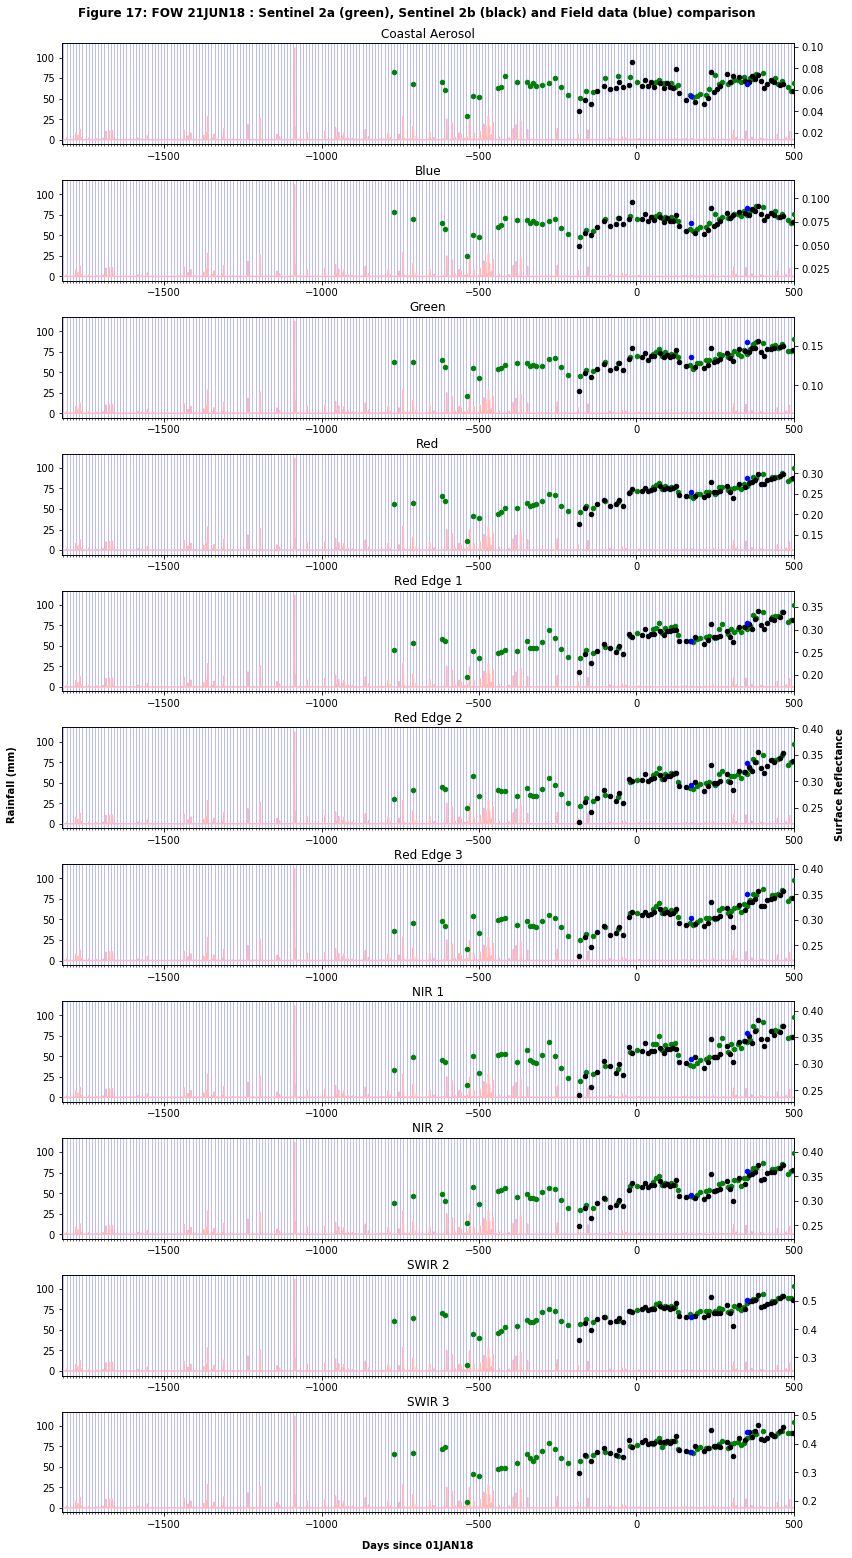

In [40]:
FIG_MultiTimeLine.FIG_multi_time_line(fls8_df, fs2a_df, fs2b_df, ls8_csvs, sent_csvs, rain_dat, field_data, output, fignum)
fignum+=1

In [41]:
dd0_ls8, dd1_ls8, dd0_s2a, dd1_s2a, dd0_s2b, dd1_s2b = CalcStats.calc_stats(fls8_df, fs2a_df, fs2b_df)

LANDSAT 8: Number of adjacent overpasses: 88
Landsat 8 Surface Reflectance for Band 1 is 0.066+/-0.006 (9.18%)
Landsat 8 Surface Reflectance for Band 2 is 0.071+/-0.006 (8.24%)
Landsat 8 Surface Reflectance for Band 3 is 0.134+/-0.007 (5.53%)
Landsat 8 Surface Reflectance for Band 4 is 0.227+/-0.012 (5.31%)
Landsat 8 Surface Reflectance for Band 5 is 0.307+/-0.013 (4.36%)
Landsat 8 Surface Reflectance for Band 6 is 0.414+/-0.015 (3.73%)
Landsat 8 Surface Reflectance for Band 7 is 0.338+/-0.018 (5.34%)

SENTINEL 2a: Number of adjacent overpasses: 62
Sentinel 2a Surface Reflectance for Band 1 is 0.065+/-0.004 (6.4%)
Sentinel 2a Surface Reflectance for Band 2 is 0.078+/-0.004 (5.03%)
Sentinel 2a Surface Reflectance for Band 3 is 0.137+/-0.005 (3.57%)
Sentinel 2a Surface Reflectance for Band 4 is 0.259+/-0.008 (3.26%)
Sentinel 2a Surface Reflectance for Band 5 is 0.295+/-0.011 (3.81%)
Sentinel 2a Surface Reflectance for Band 6 is 0.309+/-0.011 (3.47%)
Sentinel 2a Surface Reflectance for Ba

In [42]:
#MultiTimeLineDry.multi_time_line_dry(fls8_df, fs2a_df, fs2b_df, ls8_csvs, sent_csvs, rain_dat, field_data, output, fignum)

In [43]:
#FIG_MultiTimeLine.FIG_multi_time_line(fls8_df, fs2a_df, fs2b_df, ls8_csvs, sent_csvs, rain_dat, field_data, output, fignum)
#fignum+=1

In [44]:
#dd0_ls8, dd1_ls8, dd0_s2a, dd1_s2a, dd0_s2b, dd1_s2b = CalcStats.calc_stats(fls8_df, fs2a_df, fs2b_df)

## How long did this notebook take to run?

In [45]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")

This Notebook took  0:11:34 (h:m:s) to run
